# NegMAS: A platform for Automated Negotiation

**Yasser Mohammad and Amy Greenwald**    
**AAAI 2022 Tutorial**

## Installation

To get started, you only need to install NegMAS. It comes with all its dependencies.

In [1]:
# !pip install negmas

# to use genius negotiators
# !negmas genius-setup

## Importing what we need 

In [2]:
# for reproducibility
import random
random.seed(0)

# importing what we need. As usual, it is not recommended to import *
import math
from negmas import *

And visualization stuff

In [3]:
%matplotlib inline
# setup disply parameters
from rich import print
from negmas.helpers import shorten
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 6))        # set figure size
import warnings
warnings.filterwarnings('ignore')


def savefig(name, fig=None):
    if fig is None:
        fig = plt.gcf()
    for ext in ("pdf", "png"):
        plt.savefig(f"figs/{name}.{ext}", pad_inches=0.0, bbox_inches="tight")
        

## A simple negotiation

Let's write a simple function to run a negotiation in a trading scenario.

The negotiation has three issues:

1. Price which ranges from 0 to 9
2. **Quantity** which rnages from 1 to 11
3. **Delivery time** which ranges from 0 (today) to 6.
   
The preferences of the two parties can be summarized as follows:
- The buyer prefers higher prices and the seller lower prices
- Both prefre a higher quantity but the value of higher quantity is twice as important for the buyer
- The buyer prefers to deliver later and the seller has a complex preference for time that goes up then down then up again (like a sinusoidal) 

In [4]:
def run_negotiation(buyer: SAONegotiator, seller: SAONegotiator, issues=None,  scale=True):
    # create negotiation agenda (issues)
    if not issues:
        issues = [ 
            make_issue(name='price', values=10), 
            make_issue(name='quantity', values=(1, 11)), 
            make_issue(name='delivery_time', values=(0, 6)) 
        ]
    # create the mechanism
    session = SAOMechanism(issues=issues, n_steps=200)
    # define buyer and seller utilities
    buyer_utility = LinearAdditiveUtilityFunction(
        values={'price': AffineFun(-1, bias=9.0), # 9 - p
                'quantity': LinearFun(0.4),   # 0.4 q
                'delivery_time': IdentityFun()},
        outcome_space=session.outcome_space, reserved_value=6
    )
    if scale:
        buyer_utility = buyer_utility.scale_max(1.0)

    seller_utility =  LinearAdditiveUtilityFunction(
        values=[ 
            IdentityFun(),  
            LinearFun(0.2),  
            lambda x: math.sin(2 * math.pi * x / 10)  ],
        outcome_space=session.outcome_space, reserved_value=9
    )
    if scale:
        seller_utility = seller_utility.scale_max(1.0)

    # create and add buyer and seller negotiators
    session.add(buyer, ufun=buyer_utility)
    session.add(seller, preferences=seller_utility)

    # run the negotiation and show the results
    session.run(); 
    
    # give negotiators nice names (for plotting)
    buyer.name = f"buyer-{buyer.short_type_name}"
    seller.name = f"seller-{seller.short_type_name}"

    # plot the negotiation
    session.plot(show_agreement=True)


## Running your first negotiation
Let's try it

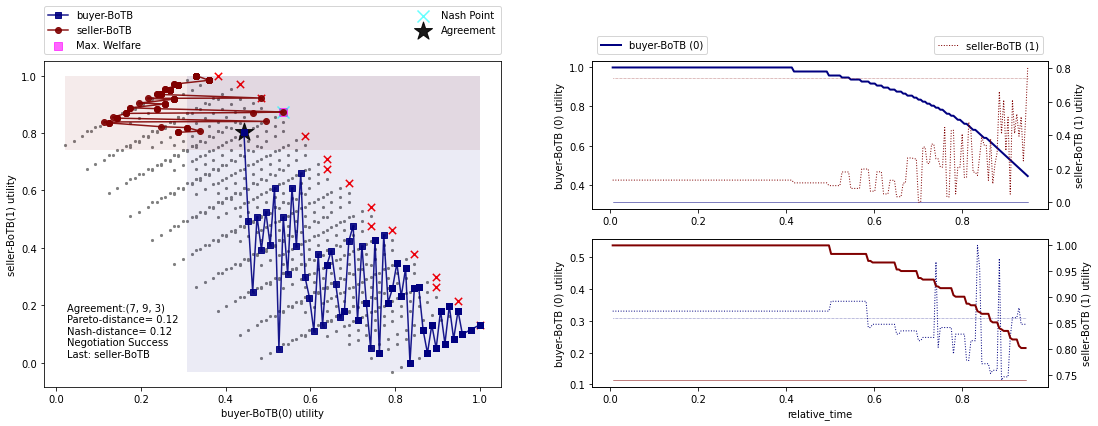

In [5]:
run_negotiation(BoulwareTBNegotiator(), BoulwareTBNegotiator())
savefig("buyerseller")

### Why did we need to scale? skip

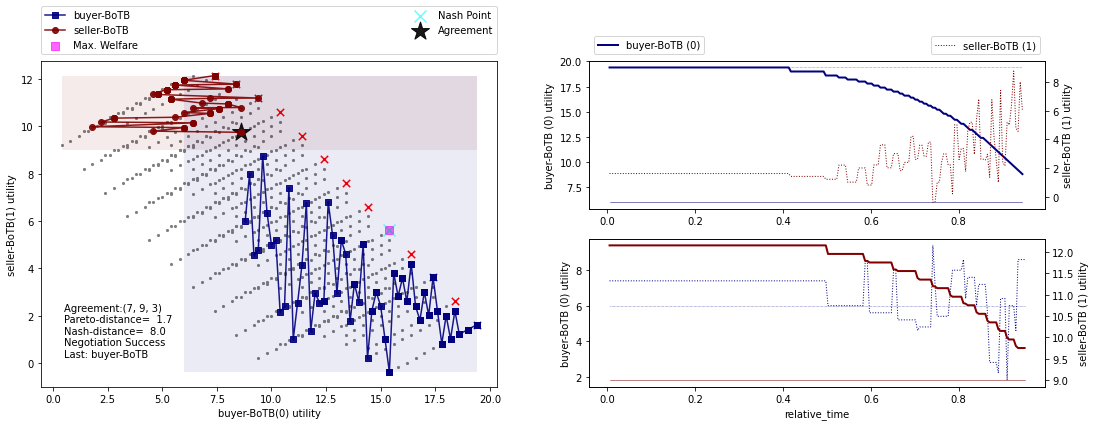

In [6]:
run_negotiation(BoulwareTBNegotiator(), BoulwareTBNegotiator(), scale=False)
savefig("buyerseller_no_scale")

### Continuous Outcome Spaces 

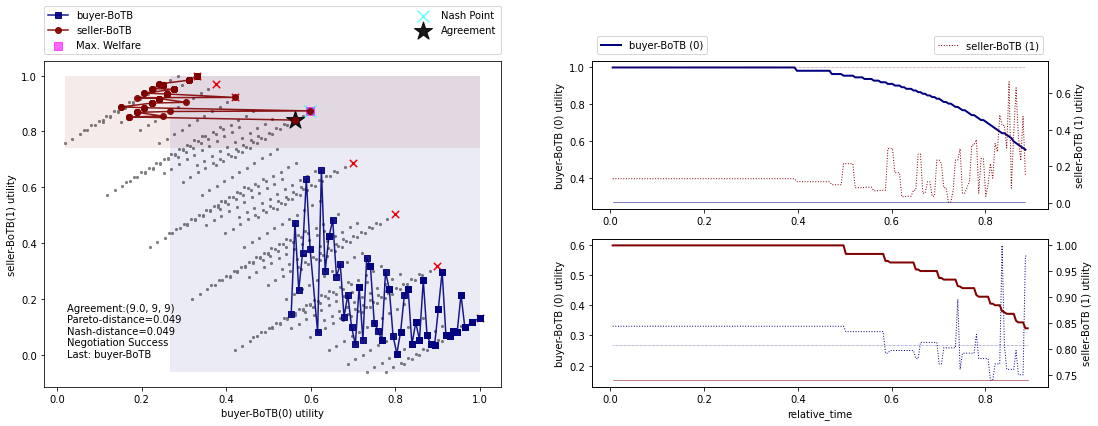

In [7]:
issues = [ 
    make_issue(name='price', values=(0.0, 9.0)), 
    make_issue(name='quantity', values=(1, 11)), 
    make_issue(name='delivery_time', values=10) 
]
run_negotiation(BoulwareTBNegotiator(), BoulwareTBNegotiator(), issues=issues)
savefig("buyerseller_continuous")

**back to the slides**

## Building a modular negotiator

NegMAS supports a generic modular negotiator type `ModularNegotiator` which is specialized for SAOP as `MAPNegotiator`. 


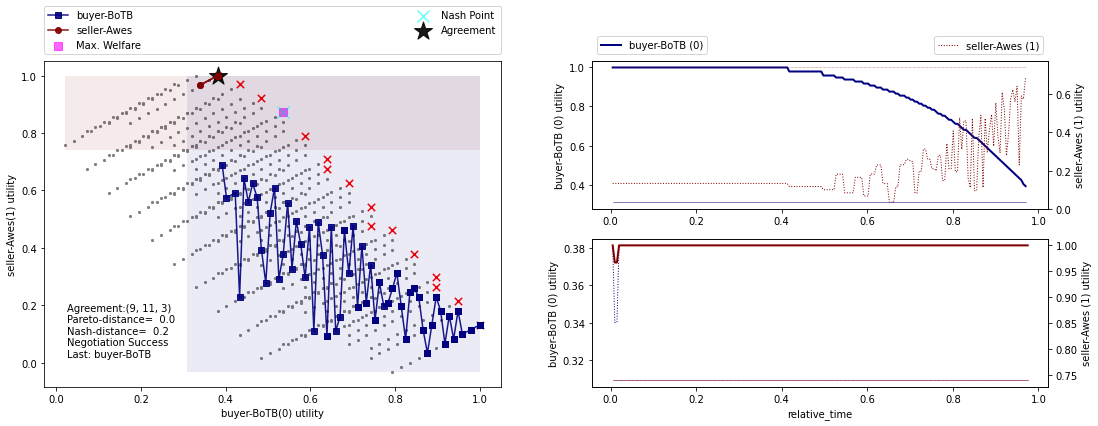

In [8]:
model = ZeroSumModel()
recommender = KindConcessionRecommender()
acceptance = AcceptAbove(0.8) or (AcceptTime(0.9) and AcceptAbove(0.5))
offering = TFTOfferingStrategy(partner_ufun=model, recommender=recommender)
negotiator = MAPNegotiator(models=[model, recommender], acceptance=acceptance, offering=offering, type_name="Awesome")
run_negotiation(BoulwareTBNegotiator(), negotiator)
savefig("buyerseller_boa")

### Using GENIUS Negotiators

Two GENIUS negotiators against each other

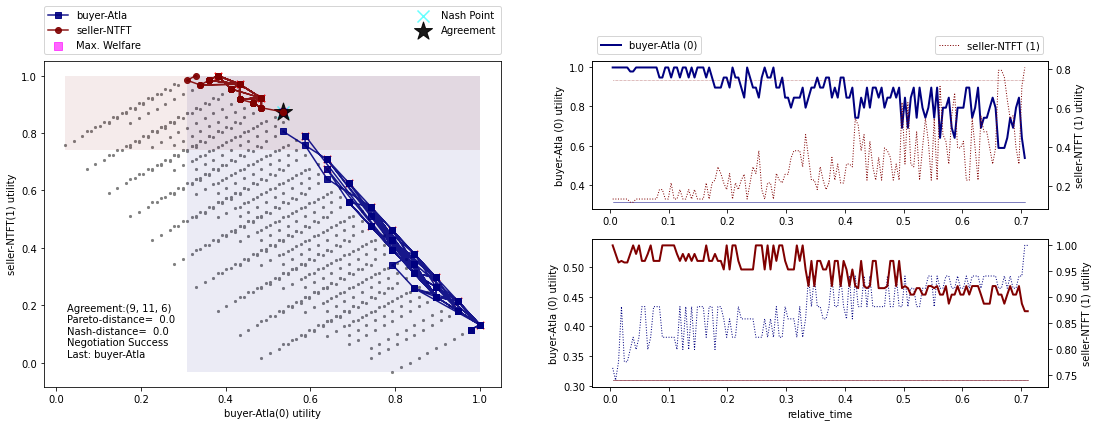

In [11]:
run_negotiation(Atlas3(), NiceTitForTat())
savefig("buyerseller_genius")

## A GENIUS negotiator against a NegMAS negotiator


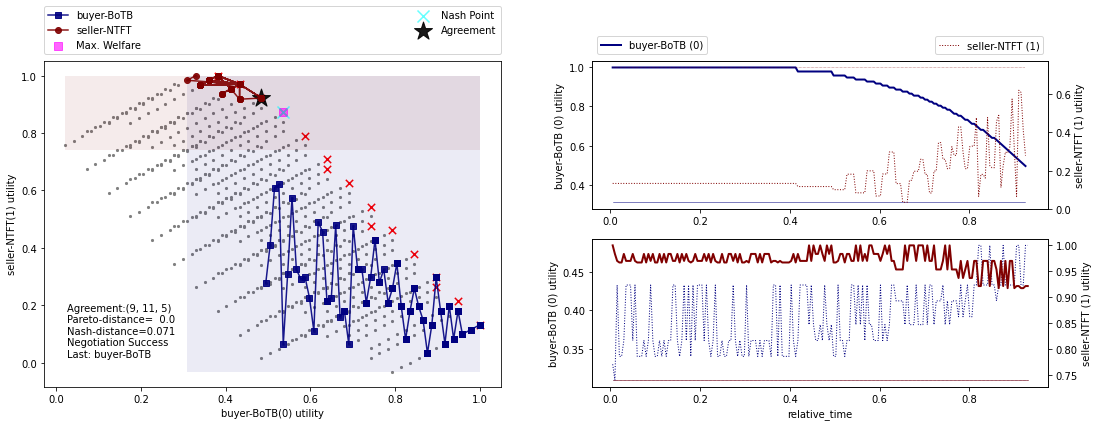

In [12]:
run_negotiation(BoulwareTBNegotiator(), NiceTitForTat())
savefig("buyerseller_mix")

**back to the slides**

## Developing our own agent

The main idea: Use a `cos` for our aspiration curve.

why? because we can :-)

In [13]:
class CosNegotiator(SAONegotiator):
    
    def on_preferences_changed(self, changes):
        super().on_preferences_changed(changes)
        self._inv = PresortingInverseUtilityFunction(self.ufun)
        self._inv.init()
    
    def propose(self, state):
        u = math.cos(state.relative_time * 4 * math.pi)
        return self._inv.worst_in((u, u + 0.1), True)
        

## Running the negotiation

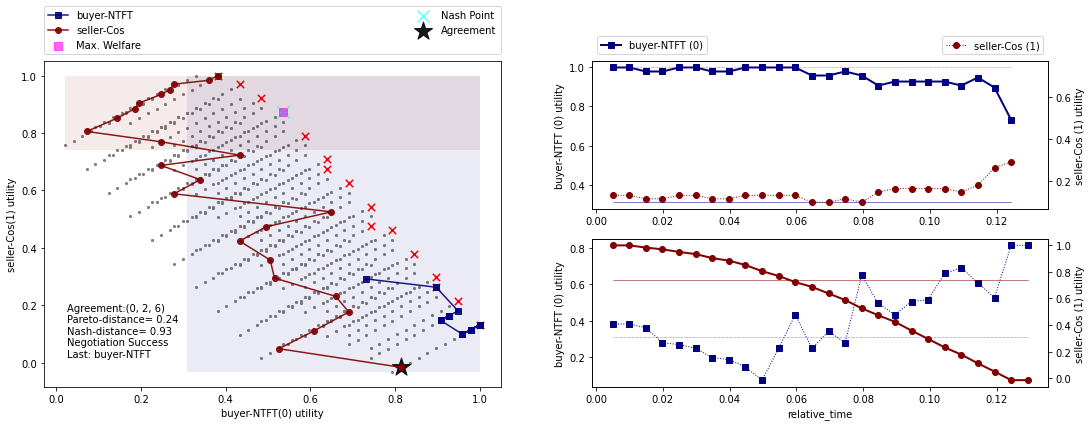

In [14]:
run_negotiation(NiceTitForTat(), CosNegotiator())
savefig("buyerseller_cos1")

A disaster. We conceded too fast. **Can you spot something crazy that our negotiator did?**

## Improving our agent

- Avoid falling under our reserved value
- Reduce our concession rate

In [15]:
class BetterCosNegotiator(SAONegotiator):
    
    def on_preferences_changed(self, changes):
        super().on_preferences_changed(changes)
        self._inv = self.ufun.invert()
        self._min, self._max = self.ufun.minmax()
        if self.reserved_value > self._min:
            self._min = self.reserved_value
    
    def propose(self, state):
        
        u = math.cos(state.relative_time * math.pi / 2) * (self._max - self._min) + self._min
        return self._inv.worst_in((u, self._max), True)
        

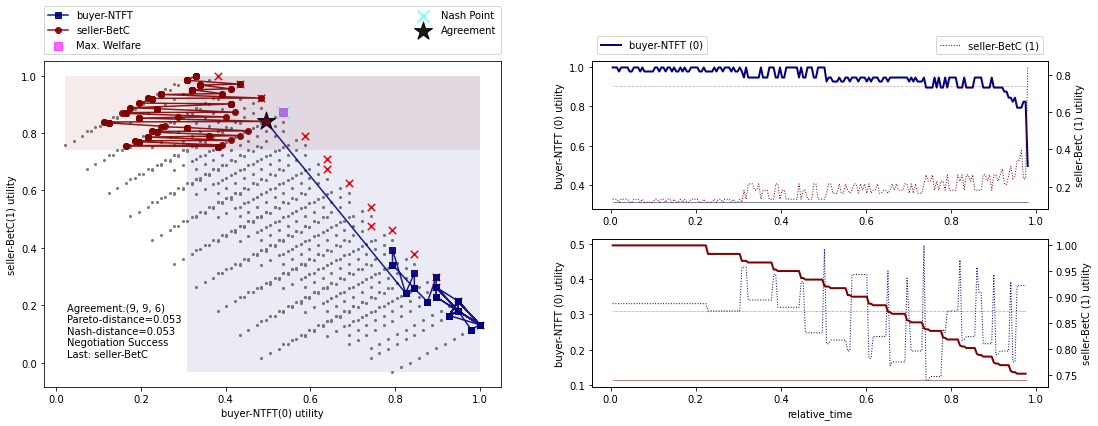

In [16]:
run_negotiation(NiceTitForTat(), BetterCosNegotiator())
savefig("buyerseller_cos2")

## Improving our agent (again)

- Accept good offers.
- Opportunisitcally offer oppoonent's best offer for us.

In [17]:
class EvenBetterCosNegotiator(BetterCosNegotiator):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._best_so_far, self._max_received = None, float("-inf") 

    def asp(self, state):
        return math.cos(state.relative_time * math.pi / 2
                       ) * (self._max - self._min) + self._min
    
    def respond(self, state, offer):
        u = self.ufun(offer)
        if u >= self._max_received:
            self._max_received = u
            self._best_so_far = offer
        if u > self.asp(state):
            return ResponseType.ACCEPT_OFFER
        return super().respond(state, offer)
    
    def propose(self, state):
        u = self.asp(state) 
        if u < self._max_received:
            return self._best_so_far
        return self._inv.one_in((u, self._max), True)
        

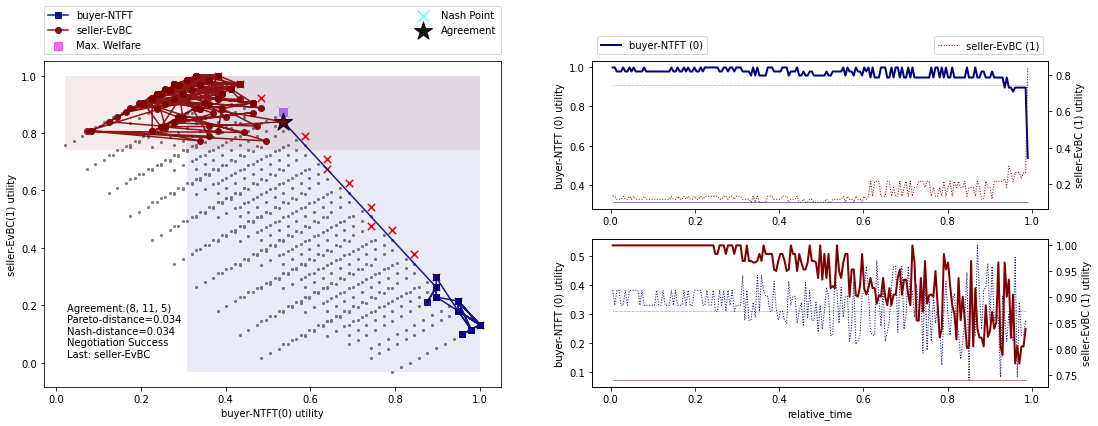

In [18]:
run_negotiation(NiceTitForTat(), EvenBetterCosNegotiator())
savefig("buyerseller_cos3")

**The END**